In [ ]:
from joblib import dump

path_to_recs_microdata = 'data/RECS/recs2020_public_v6.csv'
path_to_recs_codebook = 'data/RECS/codebook_updated.csv'#'../Data/US/RECS/RECS 2020 Codebook for Public File - v6.csv'
dir_to_templates = 'data/template/'

def KWH2BTU(kwh):
    return kwh * 3412.142
def BTU2KWH(btu):
    return btu / 3412.142
def SQM2SQF(sqm):
    return sqm * 10.7639
def SQF2SQM(sqf):
    return sqf / 10.7639
def THM2BTU(thm):
    return thm * 99976.1
def BTU2THM(btu):
    return btu / 99976.1
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pandas import set_option
from pandas import get_dummies

import seaborn as sns
import re

from collections import OrderedDict
from time import time
import sqlite3       


import warnings
warnings.filterwarnings('ignore')




#from feature_selector import FeatureSelector

#XGBoost libraries
import xgboost as xgb

from ipywidgets import interactive, fixed

import geopandas as gpd
import shapely
import math
import contextily as cx
import os
import json

#sns.set(style="whitegrid", palette="hls")
#pd.set_option('display.mpl_style', 'default')
#pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10,6
np.random.seed(0)

codebook = pd.read_csv(path_to_recs_codebook, skiprows=[0])
recs = pd.read_csv(path_to_recs_microdata, index_col=0)
templates = []
for file_name in os.listdir(dir_to_templates):
    if ('.json' in file_name) | ('.JSON' in file_name):
        templates.append(dir_to_templates + file_name)
template = json.load(open(templates[15]))
codebook = pd.read_csv(path_to_recs_codebook, skiprows=[0])
SECTIONS = codebook['Section'].unique()
def search_variable(keyword, section=None):
    if section is None:
        return codebook[codebook['Variable'].apply(lambda x: keyword.lower() in str(x).lower())]
    else:
        subbook = codebook[codebook['Section'] == section]
        return subbook[subbook['Variable'].apply(lambda x: keyword.lower() in str(x).lower())]
def search_codebook(keyword, section=None, variable=False):
    if variable:
        return search_variable(keyword, section=section)
    if section is None:
        return codebook[codebook['Description and Labels'].apply(lambda x: keyword.lower() in str(x).lower())]
    else:
        subbook = codebook[codebook['Section'] == section]
        return subbook[subbook['Description and Labels'].apply(lambda x: keyword.lower() in str(x).lower())]
def get_response_codes(variable):
    return codebook[codebook['Variable'] == variable]['Response Codes'].iloc[0]
def parse_categorical_response_codes(s):
    entries = s.split('\n')
    numeric = []
    descriptive = []
    for e in entries:
        num = e.split(' ')[0]
        des = e.removeprefix(num + ' ')
        numeric.append(num)
        descriptive.append(des)
    return pd.DataFrame({'code': numeric, 'description': descriptive})
def get_legend(variable):
    return parse_categorical_response_codes(get_response_codes(variable))
recs = pd.read_csv(path_to_recs_microdata, index_col=0)
df_raw = recs.copy()

weight_cols = search_codebook('Final Analysis Weight')['Variable'].to_numpy()[1:]
Discarded_feature = [x for x in df_raw.columns if 
                     (x.startswith('Z')) | 
                     (x.startswith('NWEIGHT') & (x != 'NWEIGHT'))] # now the weight column is in the df
df = recs.copy()

df_computed = df.copy()
# According to the codebook, replace the NA flags (-2, -4, 99, etc.) with the correct default value
for index, row in codebook[~np.isnan(codebook['Target1'])].iterrows():
    df_computed.loc[df_computed[row['Variable']] == row['Handle1'], row['Variable']] = row['Target1']

for index, row in codebook[~np.isnan(codebook['Target2'])].iterrows():
    df_computed.loc[df_computed[row['Variable']] == row['Handle2'], row['Variable']] = row['Target2']
def parse_climate_code(code):
    num = int(eval(code[0]))
    ltr = code[1:]
    return num, ltr
df_computed['climate_code_heat'] = df_computed['IECC_climate_code'].apply(lambda x: parse_climate_code(x)[0])

df_computed['climate_code_humidity'] = df_computed['IECC_climate_code'].apply(lambda x: parse_climate_code(x)[1])

df_computed = df_computed.fillna(0)

# YEARMADERANGE
mapping_year_made_range = {1: 1935, 2: 1955, 3: 1965, 4: 1975, 5: 1985, 6: 1995, 7: 2005, 8: 2015, 9: 2018}
# WINDOWS
mapping_num_windows = {1: 2, 2: 4, 3: 7, 4: 13, 5: 17, 6: 25, 7: 33}
# TYPERFR1 TYPERFR2
mapping_app_door_type = {1: 1, 2: 2, 3: 2, 4: 2, 5: 3, -2: 0}
# AGERFRI1 AGERFRI2 AGEFRZR AGEDW AGECWASH AGECDRYER WHEATAGE
mapping_app_age = {1: 1, 2: 3, 3: 7, 4: 12, 5: 17, 6: 23, -2: 0}
# NUMMEAL
mapping_meal_freq = {1: 22, 2: 14, 3: 7, 4: 4, 5: 1, 6: 0.5, 0: 0} # times per week
# USECOFFEE
mapping_coffee_freq = {1: 1, 2: 0.5, 3: 0.2, 0: 0} # use per day
# USEEQUIPAUX
mapping_sec_heat = {1: 1, 2: 0.3, 3: 0.1, 4: 0.05, 5: 0.02, -2: 0} # use per day (probability)
# USEHUMID USECFAN USEDEHUM
mapping_latent_freq = {1: 0.05, 2: 0.1, 3: 0.5, 4: 0.9, 99: 0.05, -1: 0} # use per day (probability)
# TEMPHOME TEMPGONE TEMPNITE TEMPHOMEAC TEMPGONEAC TEMPNITEAC
mapping_temp = {-2: 75}
# WHEATSIZ
mapping_tank_size = {1: 20, 2: 40, 3: 60, 4: 0}
# LGTINLED LGTINCFL LGTINCAN
mapping_portion = {1: 1, 2: 0.75, 3: 0.5, 4: 0.25, 5: 0}
# LGTOUTNITE
mapping_num_lights = {-1: 0}
# EVCHRGHOME
mapping_EV = {1: 1, 0: 0, -2: 0, '.': 0}
# MONEYPY
mapping_money = {
    1: 4000,     # Less than $5,000
    2: 6000,     # $5,000 - $7,499
    3: 8750,     # $7,500 - $9,999
    4: 11250,    # $10,000 - $12,499
    5: 13750,    # $12,500 - $14,999
    6: 17500,    # $15,000 - $19,999
    7: 22500,    # $20,000 - $24,999
    8: 27500,    # $25,000 - $29,999
    9: 32500,    # $30,000 - $34,999
    10: 37500,   # $35,000 - $39,999
    11: 45000,   # $40,000 - $49,999
    12: 55000,   # $50,000 - $59,999
    13: 67500,   # $60,000 - $74,999
    14: 87500,   # $75,000 - $99,999
    15: 125000,  # $100,000 - $149,999
    16: 175000   # $150,000 or more
}

# state_postal
mapping_state = {
    'AL': 1,
    'AK': 2,
    'AZ': 4,
    'AR': 5,
    'CA': 6,
    'CO': 8,
    'CT': 9,
    'DE': 10,
    'DC': 11,
    'FL': 12,
    'GA': 13,
    'HI': 15,
    'ID': 16,
    'IL': 17,
    'IN': 18,
    'IA': 19,
    'KS': 20,
    'KY': 21,
    'LA': 22,
    'ME': 23,
    'MD': 24,
    'MA': 25,
    'MI': 26,
    'MN': 27,
    'MS': 28,
    'MO': 29,
    'MT': 30,
    'NE': 31,
    'NV': 32,
    'NH': 33,
    'NJ': 34,
    'NM': 35,
    'NY': 36,
    'NC': 37,
    'ND': 38,
    'OH': 39,
    'OK': 40,
    'OR': 41,
    'PA': 42,
    'RI': 44,
    'SC': 45,
    'SD': 46,
    'TN': 47,
    'TX': 48,
    'UT': 49,
    'VT': 50,
    'VA': 51,
    'WA': 53,
    'WV': 54,
    'WI': 55,
    'WY': 56
}

# Correlation Dictionary
mapping_correlations = {
    # YEARMADERANGE
    'YEARMADERANGE': mapping_year_made_range,

    # WINDOWS
    'WINDOWS': mapping_num_windows,

    # TYPERFR1 TYPERFR2
    'TYPERFR1': mapping_app_door_type,
    'TYPERFR2': mapping_app_door_type,

    # AGERFRI1 AGERFRI2 AGEFRZR AGEDW AGECWASH AGECDRYER ACEQUIPAGE WHEATAGE
    'AGERFRI1': mapping_app_age,
    'AGERFRI2': mapping_app_age,
    'AGEFRZR': mapping_app_age,
    'AGEDW': mapping_app_age,
    'AGECWASH': mapping_app_age,
    'AGECDRYER': mapping_app_age,
    #'ACEQUIPAGE': mapping_app_age,
    'WHEATAGE': mapping_app_age,

    # NUMMEAL
    'NUMMEAL': mapping_meal_freq,

    # USECOFFEE
    'USECOFFEE': mapping_coffee_freq,

    # USEEQUIPAUX
    'USEEQUIPAUX': mapping_sec_heat,

    # USEHUMID USECFAN USEDEHUM
    'USEHUMID': mapping_latent_freq,
    'USECFAN': mapping_latent_freq,
    'USEDEHUM': mapping_latent_freq,

    # TEMPHOME TEMPGONE TEMPNITE TEMPHOMEAC TEMPGONEAC TEMPNITEAC
    'TEMPHOME': mapping_temp,
    'TEMPGONE': mapping_temp,
    'TEMPNITE': mapping_temp,
    'TEMPHOMEAC': mapping_temp,
    'TEMPGONEAC': mapping_temp,
    'TEMPNITEAC': mapping_temp,

    # WHEATSIZ
    'WHEATSIZ': mapping_tank_size,

    # LGTINLED LGTINCFL LGTINCAN
    'LGTINLED': mapping_portion,
    'LGTINCFL': mapping_portion,
    'LGTINCAN': mapping_portion,

    # LGTOUTNITE
    'LGTOUTNITE': mapping_num_lights,

    # EVCHRGHOME
    'EVCHRGHOME': mapping_EV,

    # MONEYPY
    'MONEYPY': mapping_money,

    # state_postal
    'state_postal': mapping_state
}


def parse_column(column, mapping, bypass_unmappable=True):
    def map_col(x):
        if x in mapping.keys():
            return mapping[x]
        else:
            if bypass_unmappable:
                return x
            else:
                return 0
    return column.apply(map_col)

for c, mapping in mapping_correlations.items():
    df_computed[c] = parse_column(df_computed[c], mapping)



known_variables = {}
template_variables = {}
known_variables['Known'] = codebook[codebook['Availability'] == 'Known']['Variable'].values.tolist()
known_variables['Imputable'] = codebook[codebook['Availability'] == 'Imputable']['Variable'].values.tolist()
for u in codebook[~codebook['Template'].isna()]['Template'].unique():
    template_variables[u] = codebook[codebook['Template'] == u]['Variable'].values.tolist()
known_variables.keys(), template_variables.keys()


df_computed['total_sqm_en'] = df['SQFTEST'].apply(SQF2SQM)

df_computed['total_kwh_elec'] = df['KWHSPH'] + df['KWHCOL'] + df['KWHWTH'] + df['KWHRFG'] + df[
'KWHFRZ'] + df['KWHCOK'] + df['KWHMICRO'] + df['KWHCW'] + df['KWHCDR'] + df['KWHDWH'] + df[
'KWHLGT'] + df['KWHTVREL'] + df['KWHAHUHEAT'] + df['KWHAHUCOL'] + df['KWHCFAN'] + df[
'KWHDHUM'] + df['KWHHUM'] + df['KWHPLPMP'] + df['KWHHTBPMP'] + df['KWHHTBHEAT'] + df[
'KWHEVCHRG'] + df['KWHNEC'] + df['KWHNEC']
df_computed['total_kwh'] = df['TOTALBTU'].apply(BTU2KWH)  * 1000
df_computed['total_kwh_sph'] = df['TOTALBTUSPH'].apply(BTU2KWH) * 1000




df_computed['ng_kwh_cooking'] = df['BTUNGCOK'].apply(BTU2KWH)  * 1000
df_computed['ng_kwh_clothes_dryers'] = df['BTUNGCDR'].apply(BTU2KWH)  * 1000 
df_computed['lp_kwh_cooking'] = df['BTULPCOK'].apply(BTU2KWH)  * 1000
df_computed['lp_kwh_clothes_dryers'] = df['BTULPCDR'].apply(BTU2KWH)  * 1000

df_computed['total_kwh_appliances'] = df['KWHRFG'] + df['KWHFRZ'] + df['KWHCOK'] + df['KWHMICRO'] + df['KWHCW'] + df['KWHCDR'] + df[
'KWHDWH'] + df_computed['ng_kwh_cooking'] + df_computed['ng_kwh_clothes_dryers'] + df_computed[
'lp_kwh_clothes_dryers'] + df_computed['lp_kwh_cooking']
df_computed['total_kwh_dhw'] = df['TOTALBTUWTH'].apply(BTU2KWH)  * 1000 
df_computed['total_kwh_lighting'] = df['KWHLGT']
df_computed['total_kwh_electronics'] = df['KWHTVREL']
df_computed['total_kwh_vent'] = df['KWHAHUHEAT'] + df['KWHAHUCOL'] + df['KWHCFAN'] + df['KWHDHUM'] + df['KWHHUM'] + df['KWHPLPMP'] + df['KWHHTBPMP']
df_computed['total_kwh_col'] = df['KWHCOL']
# combined energy categories
df_computed['total_kwh_cooking'] = df['KWHCOK'] + df_computed['ng_kwh_cooking'] + df_computed['lp_kwh_cooking']
df_computed['total_kwh_clothes_dryers'] = df['KWHCDR'] + df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers']
# per-appliance metrics
df_computed['total_kwh_per_refrigerator'] = df['KWHRFG'] / df['NUMFRIG']
df_computed['total_kwh_per_freezer'] = df['KWHFRZ'] / df['NUMFREEZ']
# ? cooktop TBD
df_computed['total_kwh_per_microwave'] = df['KWHMICRO'] / df['MICRO']

df_computed['total_catering'] =  df['KWHCOK'] + df['KWHMICRO'] +  df[
'KWHDWH'] + df_computed['ng_kwh_cooking'] +  df_computed['lp_kwh_cooking']
df_computed['total_kwh_housework'] = df['KWHCW'] + df['KWHCDR'] + df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers']



# eui metrics
df_computed['eui_kwh_sqm'] = df_computed['total_kwh']/ df_computed['total_sqm_en']
df_computed['total_elec_eui_kwh_sqm'] = df_computed['total_kwh_elec']/ df_computed['total_sqm_en']

df_computed['heating_eui_kwh_sqm'] = df_computed['total_kwh_sph']/ df_computed['total_sqm_en']

df_computed['appliances_eui_kwh_sqm'] = df_computed['total_kwh_appliances']/df_computed['total_sqm_en']
df_computed['refrigerator_eui_kwh_sqm'] = df_computed['KWHRFG']/df_computed['total_sqm_en']
df_computed['freezer_eui_kwh_sqm'] = df_computed['KWHFRZ']/df_computed['total_sqm_en']
df_computed['frigfreez_eui_kwh_sqm'] = (df_computed['KWHRFG'] + df_computed['KWHFRZ'])/df_computed['total_sqm_en']
df_computed['cooking_eui_kwh_sqm'] = df_computed['total_kwh_cooking']/df_computed['total_sqm_en']
df_computed['cooking_elec_eui_kwh_sqm'] = df_computed['KWHCOK']/df_computed['total_sqm_en']
df_computed['cooking_fuel_eui_kwh_sqm'] = (df_computed['ng_kwh_cooking'] + df_computed['lp_kwh_cooking'])/df_computed['total_sqm_en']
df_computed['clothes_dryers_eui_kwh_sqm'] = df_computed['total_kwh_clothes_dryers']/df_computed['total_sqm_en']
df_computed['clothes_dryers_elec_eui_kwh_sqm'] = df['KWHCDR']/df_computed['total_sqm_en']
df_computed['clothes_dryers_fuel_eui_kwh_sqm'] = (df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers'])/df_computed['total_sqm_en']
df_computed['housework_eui_kwh_sqm'] = df_computed['total_kwh_housework']/df_computed['total_sqm_en']
df_computed['housework_elec_eui_kwh_sqm'] = (df['KWHCW'] + df['KWHCDR'])/df_computed['total_sqm_en']
df_computed['housework_fuel_eui_kwh_sqm'] = (df_computed['ng_kwh_clothes_dryers'] + df_computed['lp_kwh_clothes_dryers'])/df_computed['total_sqm_en']

df_computed['dhw_eui_kwh_sqm'] = df_computed['total_kwh_dhw']/ df_computed['total_sqm_en']
df_computed['lighting_eui_kwh_sqm'] = df_computed['total_kwh_lighting']/ df_computed['total_sqm_en']
df_computed['electronics_eui_kwh_sqm'] = df_computed['total_kwh_electronics']/ df_computed['total_sqm_en']
df_computed['vent_eui_kwh_sqm'] = df_computed['total_kwh_vent']/ df_computed['total_sqm_en']
df_computed['cooling_eui_kwh_sqm'] = df_computed['total_kwh_col']/ df_computed['total_sqm_en']
computed_columns = ['total_sqm_en', 'total_kwh', 'total_kwh_sph', 'total_kwh_appliances', 'total_kwh_dhw', 'total_kwh_lighting', 'total_kwh_electronics', 'total_kwh_vent', 'total_kwh_col',
 'eui_kwh_sqm', 'heating_eui_kwh_sqm', 'appliances_eui_kwh_sqm', 'dhw_eui_kwh_sqm', 'lighting_eui_kwh_sqm', 'electronics_eui_kwh_sqm', 'vent_eui_kwh_sqm', 'cooling_eui_kwh_sqm']


#for col in df_computed.columns:
#    df_computed[col][df_computed[col] == -2] = 0

# These are all preprocessed feature columns
cols_discarded = codebook[codebook['Preserved'] <= .01]['Variable'].values.tolist()
cols_continuous = codebook[(codebook['Preserved'] >= 0.99) & ((codebook['Notes'] == 'Numerical') & (codebook['NaiveScale'] != 1))]['Variable'].values.tolist()
cols_scaled = codebook[(codebook['Preserved'] >= 0.99) & ((codebook['Notes'] == 'Numerical') & (codebook['NaiveScale'] == 1))]['Variable'].values.tolist() + ['climate_code_heat']
cols_categorical = codebook[(codebook['Preserved'] >= 0.99) & (codebook['Notes'] == 'Categorical')]['Variable'].values.tolist() + ['climate_code_humidity']

# These are derived/computed columns
cols_computed = ['total_sqm_en', 'total_kwh',
       'total_kwh_sph', 'total_kwh_appliances', 'total_kwh_dhw',
       'total_kwh_lighting', 'total_kwh_electronics', 'total_kwh_vent',
       'total_kwh_col', 'eui_kwh_sqm', 'heating_eui_kwh_sqm',
       'appliances_eui_kwh_sqm', 'dhw_eui_kwh_sqm', 'lighting_eui_kwh_sqm',
       'electronics_eui_kwh_sqm', 'vent_eui_kwh_sqm', 'cooling_eui_kwh_sqm']

def sep_cols(data):
    if type(data) is pd.DataFrame:
        columns = data.columns
    elif type(data) is pd.Series:
        columns = data
    else:
        columns = pd.Series(data)
    return columns[
    columns.isin(cols_continuous + cols_computed)].values, columns[
    columns.isin(cols_scaled)].values, columns[
    columns.isin(cols_categorical)].values, columns[
    columns.isin(cols_discarded)].values

def select(data, by={}):
    df_selected = data.copy()
    for key, value in by.items():
        if type(value) == list:
            df_selected = df_selected[df_selected[key].isin(value)]
        else:
            df_selected = df_selected[df_selected[key].isin([value])]
    return df_selected

from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

from sklearn.metrics import silhouette_score

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture

from kmodes.kprototypes import KPrototypes
def preprocess(df, cols_cat=np.array([]), cols_con=np.array([]), cols_scl=np.array([]), OneHot=True, con_scaler='standard', scl_scaler='minmax'):
    
    data=df.copy()

    categorical_indices = [data.columns.get_loc(col) for col in cols_cat]
    scaler_features = cols_scl
    if OneHot:
        categorical_features = cols_cat
    else:
        categorical_features = np.array([])
        scaler_features = np.concatenate([cols_scl, cols_cat])

    scalers = {'standard': lambda: StandardScaler(), 'minmax': lambda: MinMaxScaler(), 'robust': lambda: RobustScaler() }
    if con_scaler in scalers.keys():
        con_scaler = scalers[con_scaler]()
    else:
        con_scaler = StandardScaler()
    if scl_scaler in scalers.keys():
        scl_scaler = scalers[scl_scaler]()
    else:
        scl_scaler = MinMaxScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', con_scaler, cols_con),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
            ('scale', scl_scaler, scaler_features)
        ], verbose_feature_names_out=False
    ).set_output(transform='pandas')
    preprocessed_data = preprocessor.fit_transform(data)
    #preprocessed_data = preprocessed_data[data.columns]
    return preprocessed_data, categorical_indices, preprocessor

def sep_cols_and_preprocess(df, OneHot=True, con_scaler='standard', scl_scaler='minmax', **kwargs):
    ccon, cscl, ccat, cdsc = sep_cols(df)
    if 'cols_cat' in kwargs:
        ccat = kwargs['cols_cat']
    if 'cols_con' in kwargs:
        ccon = kwargs['cols_con']
    if 'cols_scl' in kwargs:
        cscl = kwargs['cols_scl']

    return preprocess(df, cols_cat=ccat, cols_con=ccon, cols_scl=cscl,
                      OneHot=OneHot, con_scaler=con_scaler, scl_scaler=scl_scaler)
# Just a basic class skeleton to work on
# Each clustering methods shall have their own way of
# constructing a Metrics class instance
from sklearn.metrics import silhouette_score, davies_bouldin_score
#from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import calinski_harabasz_score
class Metrics:
    def __init__(self, **kwargs):
        self.predictors = None
        self.predictors_performance = None
        self.pipelines = None
        self.model = None
        self.labels = None
        self.data = None
        self.AIC = None #lower
        self.BIC = None #lower
        self.silhouette = None #higher
        self.davies_bouldin = None #lower
        #self.homogeneity = None #higher
        #self.completeness = None #higher
        #self.v_measure = None #higher
        self.calinski_harabasz = None #higher
        self.RoNoE = None # Ratio of the number of elements (Tardioli et al 2018) #lower
        self.explained_variance = None
        self.total_energy_represented = 0
        self.total_energy_actual = 1
        self.energy_validator_column = []
        self.update = False
        self.__dict__.update(kwargs)
        if self.update:
            self.update_metrics()
    def update_metrics(self):
        self.silhouette =  silhouette_score(self.data, self.labels)
        self.davies_bouldin = davies_bouldin_score(self.data, self.labels)
        self.calinski_harabasz = calinski_harabasz_score(self.data, self.labels)
        counts = [np.sum(self.labels == label) for label in np.unique(self.labels)]
        self.RoNoE = np.min(counts) / np.max(counts)
        self.explained_variance = calculate_explained_variance(self.data, self.labels)

def calculate_explained_variance(data, labels):
    """
    Calculate the Explained Variance for clustered data.

    Parameters:
    - data: np.ndarray, shape (n_samples, n_features)
        The input data.
    - labels: np.ndarray, shape (n_samples,)
        Cluster labels for each point.

    Returns:
    - explained_variance: float
        The proportion of total variance explained by the clustering.
    """
    # Compute the overall mean of the data
    overall_mean = np.mean(data, axis=0)
    
    # Total Variance: Sum of squared distances from the overall mean
    total_variance = np.sum((data - overall_mean) ** 2)
    
    # Initialize Within-Cluster Variance
    within_cluster_variance = 0.0
    
    # Iterate through each unique cluster
    for cluster in np.unique(labels):
        # Select data points belonging to the current cluster
        cluster_data = data[labels == cluster]
        
        # Compute the centroid of the current cluster
        cluster_centroid = np.mean(cluster_data, axis=0)
        
        # Sum of squared distances from the cluster centroid
        cluster_variance = np.sum((cluster_data - cluster_centroid) ** 2)
        
        # Accumulate within-cluster variance
        within_cluster_variance += cluster_variance
    
    # Calculate Explained Variance
    explained_variance = (total_variance - within_cluster_variance) / total_variance
    
    return np.mean(explained_variance)


def GMM(data, n=2, seed=0):
    np.random.seed(seed)
    gmm = GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(data)
    return gmm


def kmeans(data, weights=None, n=2, random_state=42):
    kmeans = KMeans(n_clusters=n, random_state=random_state)
    if weights is None:
        kmeans.fit(data)
    else:
        kmeans.fit(data, sample_weight=weights)
    return kmeans
def kmeans_bic_aic(kmeans, X):
    """
    Calculate BIC and AIC for a fitted KMeans model.

    Parameters:
    - kmeans: Fitted KMeans model.
    - X: Data array of shape (n_samples, n_features).

    Returns:
    - bic: Bayesian Information Criterion.
    - aic: Akaike Information Criterion.
    """
    # Number of clusters and parameters
    n_clusters = kmeans.n_clusters
    n_features = X.shape[1]
    n_samples = X.shape[0]

    # Calculate the log-likelihood
    # Assuming spherical Gaussian distribution
    # Sum of squared distances to cluster centers
    sse = kmeans.inertia_
    
    # Estimate variance
    variance = sse / (n_samples - n_clusters)
    
    # Number of parameters: cluster centers and variance
    # Each center has n_features parameters
    # Plus one parameter for variance
    n_parameters = n_clusters * n_features + 1

    # Calculate log-likelihood
    log_likelihood = -0.5 * n_samples * (n_features * np.log(2 * np.pi * variance) + 1)

    # Calculate AIC and BIC
    aic = 2 * n_parameters - 2 * log_likelihood
    bic = np.log(n_samples) * n_parameters - 2 * log_likelihood

    return bic, aic


def kmeans_wcss(model):
    return model.inertia_
def kmeans_sscore(data, model):
    return silhouette_score(data, model.labels_)


from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
def hierarchical_clustering(data):
    Z = linkage(data, method='ward', metric='euclidean')
    return Z
# dendrogram(Z)
def hierarchical_labels(link, n=3):
    return cut_tree(link, n).flatten()
def hierarchical_kn(data, n=2, n_neighbors=10):
    connectivity = kneighbors_graph(data, n_neighbors=n_neighbors, include_self=False)
    ward = AgglomerativeClustering(
        n_clusters=n, connectivity=connectivity, linkage="ward"
    ).fit(data)
    return ward
def evaluate_kmeans_simple(data, n_min=2, n_max=20):
    n_max = min(n_max, data.shape[0] - 1)
    n_min = max(2, n_min)
    metrics = []
    range_n = range(n_min, n_max + 1)

    for n in range_n:
        km = kmeans(data, weights=df_raw['NWEIGHT'].loc[data.index], n=n, random_state=42)
        metric = Metrics(model=km, data=data, labels=km.labels_, update=True)
        bic, aic = kmeans_bic_aic(km, data)
        metric.BIC = bic
        metric.AIC = aic
        
        centroids = km.cluster_centers_
        counts = np.unique_counts(km.labels_).counts

        metrics.append(metric)
        
    return range_n, metrics
def evaluate_kmeans(data, n_min=2, n_max=20, energy_validator_column='total_kwh'):
    n_max = min(n_max, data.shape[0] - 1)
    n_min = max(2, n_min)
    metrics = []
    range_n = range(n_min, n_max + 1)
    if type(energy_validator_column) == str:
        energy_validator_column = df_computed[energy_validator_column]
        total_energy_actual = np.sum(df_computed['NWEIGHT'].loc[data.index] * energy_validator_column.loc[data.index])
    else:
        total_energy_actual = np.sum(energy_validator_column.loc[data.index] * df_computed['NWEIGHT'].loc[data.index])
    for n in range_n:
        km = kmeans(data, weights=df_raw['NWEIGHT'].loc[data.index], n=n, random_state=42)
        metric = Metrics(model=km, data=data, labels=km.labels_, update=True)
        bic, aic = kmeans_bic_aic(km, data)
        metric.BIC = bic
        metric.AIC = aic
        
        centroids = km.cluster_centers_
        counts = np.unique_counts(km.labels_).counts

        total_energy = 0
        for i in range(len(centroids)):
            centroid = centroids[i]
            distances = np.linalg.norm(data - centroid, axis=1)
            closest_sample_index = data.index[np.argmin(distances)]
            total_energy = total_energy + (energy_validator_column.loc[closest_sample_index] * df_computed['NWEIGHT'].loc[closest_sample_index]) * counts[i]
        
        metric.total_energy_represented = total_energy  / total_energy_actual
        metric.energy_validator_column = energy_validator_column
        metric.total_energy_actual = total_energy_actual
        metrics.append(metric)
        
    return range_n, metrics
def evaluate_gmm(data, n_min=2, n_max=20):
    n_max = min(n_max, data.shape[0] - 1)
    n_min = max(2, n_min)
    metrics = []
    range_n = range(n_min, n_max + 1)
    for n in range_n:
        gmm = GMM(data, n=n)
        metric = Metrics(model=gmm, data=data, labels=gmm.predict(data), update=True)
        metric.update_metrics()
        metric.AIC = gmm.aic(data)
        metric.BIC = gmm.bic(data)
        metrics.append(metric)
    return range_n, metrics
def evaluate_hierarchical(data, n_min=2, n_max=20):
    n_max = min(n_max, data.shape[0] - 1)
    n_min = max(2, n_min)
    metrics = []
    range_n = range(n_min, n_max + 1)
    for n in range_n:
        hc = hierarchical_clustering(data)
        metric = Metrics(model=hc, data=data, labels=hierarchical_labels(hc, n=n), update=True)
        metrics.append(metric)
    return range_n, metrics
def evaluate_hierarchical_kn(data, k=10, n_min=2, n_max=20):
    n_max = min(n_max, data.shape[0] - 1)
    n_min = max(2, n_min)
    metrics = []
    range_n = range(n_min, n_max + 1)
    for n in range_n:
        hc = hierarchical_kn(data, n=n, n_neighbors=k)
        metric = Metrics(model=hc, data=data, labels=hc.labels_, update=True)
        metrics.append(metric)
    return range_n, metrics


def get_total_energy_represented(data, km, actual, vali):
    centroids = km.cluster_centers_
    counts = np.unique_counts(km.labels_).counts

    total_energy = 0
    for i in range(len(centroids)):
        centroid = centroids[i]
        distances = np.linalg.norm(data - centroid, axis=1)
        closest_sample_index = data.index[np.argmin(distances)]
        total_energy = total_energy + (vali.loc[closest_sample_index] * df_computed['NWEIGHT'].loc[closest_sample_index]) * counts[i]
    return total_energy  / actual


def plot_evaluation(range_n, metrics_dict):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), layout='tight')
    for key, value in metrics_dict.items():
        axes[0].plot(range_n, [m.silhouette for m in value], label=key, marker='o', markersize=3)
        axes[1].plot(range_n, [m.davies_bouldin for m in value], label=key, marker='o', markersize=3)
        axes[2].plot(range_n, [m.calinski_harabasz for m in value], label=key, marker='o', markersize=3)
        axes[3].plot(range_n, [m.RoNoE for m in value], label=key, marker='o', markersize=3)
        #axes[4].plot(range_n, [m.explained_variance for m in value], label=key, marker='o', markersize=3)
    axes[0].set_ylabel('Silhouette Score')
    axes[1].set_ylabel('Davies-Bouldin Score')
    axes[2].set_ylabel('Calinski-Harabasz Score')
    axes[3].set_ylabel('RoNoE')
    for ax in axes:
        ax.set_xlabel('# of Clusters')
        ax.legend(prop={'size': 8})
        ax.set_xticks(range_n)
        ax.tick_params(axis='x', labelsize=10, rotation=90)
        ax.set_xlim(range_n[0] - 1, range_n[-1]+1)
    return fig, axes
def plot_evaluation_extended(range_n, metrics_dict):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), layout='tight')
    for key, value in metrics_dict.items():
        axes[0][0].plot(range_n, [m.silhouette for m in value], label=key, marker='o', markersize=3)
        axes[0][1].plot(range_n, [m.davies_bouldin for m in value], label=key, marker='o', markersize=3)
        axes[0][2].plot(range_n, [m.calinski_harabasz for m in value], label=key, marker='o', markersize=3)
        axes[1][0].plot(range_n, [m.RoNoE for m in value], label=key, marker='o', markersize=3)
        axes[1][1].plot(
            np.concat([[0], range_n]),
            np.concat(
                [
                    [get_total_energy_represented(
                        value[0].data,
                        kmeans(
                            value[0].data,
                            weights=df_raw['NWEIGHT'].loc[value[0].data.index],
                            n=1,
                            random_state=42),
                        value[0].total_energy_actual,
                        value[0].energy_validator_column
                    ) - 1],
                [m.total_energy_represented - 1 for m in value]
                ]
            ),
                        label=key, marker='o', markersize=3)
        bic = np.array([m.BIC for m in value])
        #bic = (bic - np.min(bic)) / (np.max(bic) - np.min(bic)) # normalized BIC
        bic = bic / value[0].data.shape[0]
        #axes[1][2].plot(range_n, bic, label=key, marker='o', markersize=3)
        axes[1][2].plot(
            np.concat([[0], range_n]),
            np.concat(
                [
                    [np.where(np.abs(get_total_energy_represented(
                    value[0].data,
                        kmeans(
                            value[0].data,
                            weights=df_raw['NWEIGHT'].loc[value[0].data.index],
                            n=1,
                            random_state=42),
                        value[0].total_energy_actual,
                        value[0].energy_validator_column
                    ) - 1)<0.4, 1, 0.1) * 0.6],
                [np.where(np.abs(m.total_energy_represented - 1)<0.4,1, 0.1) * ((m.silhouette + 1) / 2) for m in value]
                ]
            ),
                        label=key, marker='o', markersize=3)
    axes[0][0].set_ylabel('Silhouette Score')
    axes[0][1].set_ylabel('Davies-Bouldin Score')
    axes[0][2].set_ylabel('Calinski-Harabasz Score')
    axes[1][0].set_ylabel('RoNoE')
    axes[1][1].set_ylabel('Energy Consumption Represented')
    axes[1][2].set_ylabel('Normalized BIC')
    for ax in axes.flatten():
        ax.set_xlabel('# of Clusters')
        ax.legend(prop={'size': 8})
        ax.set_xticks(range_n)
        ax.tick_params(axis='x', labelsize=10, rotation=90)
        ax.set_xlim(range_n[0] - 1, range_n[-1]+1)
    return fig, axes


In [40]:
buildings = pd.concat([
    pd.read_csv('../../Notebooks/final/buildings_all_attributes.csv', index_col=0),
    gpd.read_file('../../Notebooks/final/buildings_geoemtry.geojson', index_col=0),
], axis=1)
#parcel_attr = gpd.read_file('final/parcel_recs_coded_attributes.csv')
#parcel_geo = gpd.read_file('final/parcel_recs_coded_geometry.geojson')
#del parcel_attr['geometry']
#parcels = gpd.GeoDataFrame(pd.concat([parcel_attr.set_index('ubid'), parcel_geo.set_index('ubid')], axis=1))
def make_groups(w, mapping, default=0):
    if w in mapping.keys():
        return mapping[w]
    else:
        return default
walltype_group = {1: 16, 2: 2, 3: 3, 4: 16, 5: 2, 6: 16, 7: 16, 99: 99}
acequipm_pub_group = {1: 1}
df_computed['walltype_grouped'] = df_computed['WALLTYPE'].apply(lambda x: make_groups(x, walltype_group))
df_computed['acequipm_pub_grouped'] = df_computed['ACEQUIPM_PUB'].apply(lambda x: make_groups(x, acequipm_pub_group, default=0))
df_computed['urban_grouped'] = df_computed['UATYP10'].apply(lambda x: 0 if x == 'R' else 1)
df_computed['num_u65'] = df_computed['NUMCHILD'] + df_computed['NUMADULT1']
df_computed['num_occupant'] = df_computed['NUMCHILD'] + df_computed['NUMADULT1'] + df_computed['NUMADULT2']

df_computed['total_kwh_elec_sph'] = df['KWHSPH'] + df['KWHAHUHEAT']
df_computed['total_kwh_elec_fr'] = df['KWHRFG'] + df['KWHFRZ']
df_computed['total_kwh_elec_catering'] = df['KWHCOK'] + df['KWHMICRO'] 
df_computed['total_kwh_elec_housework'] = df['KWHCDR'] + df['KWHCW'] + df['KWHDWH']  
df_computed['total_kwh_elec_lighting'] =  df['KWHLGT']
df_computed['total_kwh_elec_electronics'] =  df['KWHTVREL']
df_computed['total_kwh_elec_col'] = df['KWHAHUCOL'] + df['KWHCFAN']
df_computed['total_kwh_elec_latent'] = df['KWHDHUM'] + df['KWHHUM']
df_computed['total_kwh_elec_ev'] = df['KWHEVCHRG']
df_computed['total_kwh_elec_dhw'] = df['KWHHTBHEAT'] + df['KWHWTH'] 
df_computed['total_kwh_elec_other'] = df['KWHPLPMP'] + df['KWHHTBPMP'] + df['KWHHTBHEAT'] + df['KWHNEC']

df_computed['total_kwh_elec_thermal'] = df_computed['total_kwh_elec_sph'] + df_computed['total_kwh_elec_col'] + df_computed['total_kwh_elec_latent'] + df_computed['total_kwh_elec_dhw']
df_computed['total_kwh_elec_constant'] = df_computed['total_kwh_elec_fr'] + df_computed['total_kwh_elec_lighting'] 
df_computed['total_kwh_elec_activity'] = df_computed['total_kwh_elec_catering']  + df_computed['total_kwh_elec_housework'] + df_computed['total_kwh_elec_ev'] + df_computed['total_kwh_elec_electronics'] + + df_computed['total_kwh_elec_other'] 




df_computed['RC_equipment_power'] = df_computed[
'total_kwh_elec_fr'] + df_computed['total_kwh_elec_catering'] + df_computed['total_kwh_elec_housework'] + df_computed[
'total_kwh_elec_electronics'] + df_computed['total_kwh_elec_other'] + df_computed[
'total_kwh_elec_ev'] + df_computed['total_kwh_elec_latent']



df_computed['total_btu_ng'] = df['BTUNG']
df_computed['total_btu_ng_sph'] = df['BTUNGSPH']
df_computed['total_btu_ng_dhw'] = df['BTUNGWTH'] + df['BTUNGPLHEAT'] + df['BTUNGHTBHEAT']
df_computed['total_btu_ng_catering'] = df['BTUNGCOK']
df_computed['total_btu_ng_housework'] = df['BTUNGCDR']
df_computed['total_btu_ng_other'] = df['BTUNGNEC']

df_computed['total_btu_ofuel'] = df['BTULP'] + df['BTUFO'] + df['BTUWD']
df_computed['total_btu_ofuel_sph'] = df['BTULPSPH'] + df['BTUFOSPH'] + df['BTUWD']
df_computed['total_btu_ofuel_dhw'] = df['BTULPWTH'] + df['BTUFOWTH']
df_computed['total_btu_ofuel_catering'] = df['BTULPCOK']
df_computed['total_btu_ofuel_housework'] = df['BTULPCDR']
df_computed['total_btu_ofuel_other'] = df['BTULPNEC'] + df['BTUFONEC']

df_computed['total_btu_ng_thermal'] = df_computed['total_btu_ng_sph'] 
df_computed['total_btu_ng_activity'] = df_computed['total_btu_ng_housework'] + df_computed['total_btu_ng_dhw'] + df_computed['total_btu_ng_catering'] + df_computed['total_btu_ng_other']

df_computed['total_btu_ofuel_thermal'] = df_computed['total_btu_ofuel_sph'] 
df_computed['total_btu_ofuel_activity'] = df_computed['total_btu_ofuel_housework'] + df_computed['total_btu_ofuel_dhw'] + df_computed['total_btu_ofuel_catering'] + df_computed['total_btu_ofuel_other']

df_computed['RC_gas_power'] =  df_computed['total_btu_ofuel_catering'] + df_computed[
'total_btu_ofuel_housework'] + df_computed['total_btu_ofuel_other'] + df_computed['total_btu_ng_catering'] + df_computed['total_btu_ng_housework'] + df_computed['total_btu_ng_other']




#----------------------------------#
df_computed['pp_kwh_elec'] = df['KWH'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_sph'] = df_computed['total_kwh_elec_sph'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_fr'] = df_computed['total_kwh_elec_fr'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_catering'] = df_computed['total_kwh_elec_catering']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_housework'] = df_computed['total_kwh_elec_housework']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_lighting'] =  df_computed['total_kwh_elec_lighting']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_electronics'] =  df_computed['total_kwh_elec_electronics']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_col'] = df_computed['total_kwh_elec_col']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_latent'] = df_computed['total_kwh_elec_latent']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_ev'] = df_computed['total_kwh_elec_ev']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_dhw'] = df_computed['total_kwh_elec_dhw']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_other'] = df_computed['total_kwh_elec_other']/ df_computed['num_occupant'] 

df_computed['pp_kwh_elec_thermal'] = df_computed['total_kwh_elec_thermal'] / df_computed['num_occupant'] 
df_computed['pp_kwh_elec_constant'] = df_computed['total_kwh_elec_constant']/ df_computed['num_occupant'] 
df_computed['pp_kwh_elec_activity'] = df_computed['total_kwh_elec_activity']/ df_computed['num_occupant'] 

df_computed['pp_btu_ng'] = df['BTUNG'] / df_computed['num_occupant'] 
df_computed['pp_btu_ng_sph'] = df_computed['total_btu_ng_sph']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_dhw'] = df_computed['total_btu_ng_dhw']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_catering'] = df_computed['total_btu_ng_catering']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_housework'] = df_computed['total_btu_ng_housework']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_other'] = df_computed['total_btu_ng_other']/ df_computed['num_occupant'] 

df_computed['pp_btu_ng_thermal'] = df_computed['total_btu_ng_thermal']/ df_computed['num_occupant'] 
df_computed['pp_btu_ng_activity'] = df_computed['total_btu_ng_activity']/ df_computed['num_occupant'] 

df_computed['pp_btu_ofuel_thermal'] = df_computed['total_btu_ofuel_thermal']/ df_computed['num_occupant'] 
df_computed['pp_btu_ofuel_activity'] = df_computed['total_btu_ofuel_activity']/ df_computed['num_occupant'] 
#----------------------------------#
df_computed['eui_kwh_elec'] = df['KWH'] / df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_sph'] = df_computed['total_kwh_elec_sph'] / df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_fr'] = df_computed['total_kwh_elec_fr'] / df_computed['total_sqm_en']
df_computed['eui_kwh_elec_catering'] = df_computed['total_kwh_elec_catering']/ df_computed['total_sqm_en']
df_computed['eui_kwh_elec_housework'] = df_computed['total_kwh_elec_housework']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_lighting'] =  df_computed['total_kwh_elec_lighting']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_electronics'] =  df_computed['total_kwh_elec_electronics']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_col'] = df_computed['total_kwh_elec_col']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_latent'] = df_computed['total_kwh_elec_latent']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_ev'] = df_computed['total_kwh_elec_ev']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_dhw'] = df_computed['total_kwh_elec_dhw']/ df_computed['total_sqm_en'] 
df_computed['eui_kwh_elec_other'] = df_computed['total_kwh_elec_other']/ df_computed['total_sqm_en'] 

df_computed['eui_kwh_elec_thermal'] = df_computed['total_kwh_elec_thermal'] / df_computed['total_sqm_en']
df_computed['eui_kwh_elec_constant'] = df_computed['total_kwh_elec_constant']/ df_computed['total_sqm_en']
df_computed['eui_kwh_elec_activity'] = df_computed['total_kwh_elec_activity']/ df_computed['total_sqm_en'] 

df_computed['RC_equipment_power_density'] = df_computed['RC_equipment_power'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_DHW_elec_power_density'] = df_computed['total_kwh_elec_dhw'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_DHW_gas_power_density'] = (df_computed['total_btu_ofuel_dhw'] + df_computed['total_btu_ng_dhw']) / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_gas_power_density'] = df_computed['RC_gas_power'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]
df_computed['RC_lighting_power_density'] = df_computed['KWHLGT'] / df_computed['total_sqm_en'] * 1000 / 8760 # [W/m2]

df_computed['eui_btu_ng'] = df['BTUNG'] / df_computed['total_sqm_en'] 
df_computed['eui_btu_ng_sph'] = df_computed['total_btu_ng_sph']/ df_computed['total_sqm_en'] 
df_computed['eui_btu_ng_dhw'] = df_computed['total_btu_ng_dhw']/ df_computed['total_sqm_en']
df_computed['eui_btu_ng_catering'] = df_computed['total_btu_ng_catering']/df_computed['total_sqm_en']
df_computed['eui_btu_ng_housework'] = df_computed['total_btu_ng_housework']/ df_computed['total_sqm_en']
df_computed['eui_btu_ng_other'] = df_computed['total_btu_ng_other']/ df_computed['total_sqm_en']

df_computed['eui_btu_ng_thermal'] = df_computed['total_btu_ng_thermal']/ df_computed['total_sqm_en']  
df_computed['eui_btu_ng_activity'] = df_computed['total_btu_ng_activity']/ df_computed['total_sqm_en']  

df_computed['eui_btu_ofuel'] = df_computed['total_btu_ofuel'] / df_computed['total_sqm_en']
df_computed['eui_btu_ofuel_sph'] = df_computed['total_btu_ofuel_sph'] / df_computed['total_sqm_en']
df_computed['eui_btu_ofuel_thermal'] = df_computed['total_btu_ofuel_thermal']/ df_computed['total_sqm_en']  
df_computed['eui_btu_ofuel_activity'] = df_computed['total_btu_ofuel_activity']/ df_computed['total_sqm_en']  

df_computed['RC_electrity'] = df_computed['total_kwh_elec']
df_computed['RC_ofuel'] = df_computed['total_btu_ofuel'].apply(BTU2KWH) * 1000

df_computed['RC_lighting'] =  df_computed['KWHLGT']
df_computed['RC_heating'] = df_computed['TOTALBTUSPH'].apply(BTU2KWH) * 1000
df_computed['RC_cooling'] = df_computed['KWHCOL']
df_computed['RC_DHW'] = df_computed['total_kwh_elec_dhw']  + (df['BTULPWTH'] + df['BTUFOWTH'] + df['BTUNGWTH'] + df['BTUNGPLHEAT'] + df['BTUNGHTBHEAT']).apply(BTU2KWH) * 1000
df_computed['RC_auxiliary'] = df_computed['KWHCFAN'] + df_computed['KWHAHUCOL'] + df_computed['KWHAHUHEAT']

df_computed['RC_electricity_eui'] = df_computed['RC_electrity']  / df_computed['total_sqm_en']
df_computed['RC_ofuel_eui'] = df_computed['RC_ofuel'] / df_computed['total_sqm_en']
df_computed['RC_lighting_eui'] = df_computed['RC_lighting'] / df_computed['total_sqm_en']
df_computed['RC_heating_eui'] = df_computed['RC_heating'] / df_computed['total_sqm_en']
df_computed['RC_cooling_eui'] = df_computed['RC_cooling'] / df_computed['total_sqm_en']
df_computed['RC_DHW_eui'] = df_computed['RC_DHW']  / df_computed['total_sqm_en']
df_computed['RC_equipment_eui'] = df_computed['RC_equipment_power'] / df_computed['total_sqm_en']
df_computed['RC_gas_power_eui'] = df_computed['RC_gas_power'] / df_computed['total_sqm_en']
df_computed['RC_auxiliary_eui'] = df_computed['RC_auxiliary'] / df_computed['total_sqm_en']





existing_cols = {
    'usace_sqft': 'TOTSQFT_EN',
    #'year_built': 'YEARMADERANGE',
    'typehuq': 'TYPEHUQ',
    'urban': 'urban_grouped',
    'acequipm_pub': 'acequipm_pub_grouped',
    'fuelheat': 'FUELHEAT',
    'equipm': 'EQUIPM',
    'year_built': 'YEARMADERANGE',
    'cellar': 'CELLAR',
    'wall_type': 'WALLTYPE',
    'basefin': 'BASEFIN',
    'num_u65': 'num_u65',
    'num_o65': 'NUMADULT2',
    'el_annual': 'corrected_kwh',
    'gs_annual': 'corrected_thmng'
}

buildings_known = buildings[existing_cols.keys()]
buildings_known = buildings_known.rename(columns=existing_cols)

In [94]:
from matplotlib.cm import get_cmap

# Get the Set1 colormap
cmap = get_cmap('Set1')

def plot_cluster_result_bars(da, metric, ccon=None, ccat=None):
    cccat, cccon = auto_detect_cat(da)
    if ccon is None:
        ccon = cccon
    if ccat is None:
        ccat = cccat
        
    da_clustered = df_computed.loc[da.index]
    da_clustered['label'] = metric.labels
    for c in ccon:
        categorical_numeric_bar(da_clustered, 'label', c)
    for c in ccat:
        categorical_categorical_bar(da_clustered, 'label', c)
def cluster_subset(ccat, ccon, subset, cluster_method, bic_only=False):
    attributes = ccat + ccon
    indices = select(df, by=subset).index
    da = df_computed.loc[indices][attributes]
    #ccat, ccon = auto_detect_cat(da)
    interval, metrics = cluster_method(sep_cols_and_preprocess(da, cols_cat=ccat, cols_con=ccon, cols_scl=[])[0])
    if bic_only:
        fig, axes = plt.subplots(1, 1, figsize=(5, 5), layout='constrained')
        bics = [m.BIC for m in metrics]
        bmax = np.max(bics)
        bmin = np.min(bics)
        axes.plot(interval, bics, marker='o', markersize=5)
        axes.set_xticks(interval, interval)
        axes.set_ylabel('BIC')
        axes.set_xlabel('Number of Clusters')
        axes.grid(True)
        ss = [m.silhouette for m in metrics]
        smax = np.max(ss)
        smin = np.min(ss)
        axes.bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics], .4, bottom=bmin, alpha=0.5, label='Prediction Accuracy')
        axes.legend()
        bg = (bmax - bmin) * 0.01
        sg = (smax - smin) * 0.01
        axes.set_ylim(bmin - bg, bmax + bg)
        return da, metrics
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    bics = [m.BIC for m in metrics]
    bmax = np.max(bics)
    bmin = np.min(bics)
    axes[0].plot(interval, bics, marker='o', markersize=5)
    axes[0].set_xticks(interval, interval)
    axes[0].set_ylabel('BIC')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].grid(True)
    ss = [m.silhouette for m in metrics]
    smax = np.max(ss)
    smin = np.min(ss)
    axes[1].plot(interval, ss, marker='o', markersize=5)
    axes[1].set_xticks(interval, interval)
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].grid(True)
    
    axes[0].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics], .4, bottom=bmin, alpha=0.5, label='Prediction Accuracy')
    axes[1].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (smax - smin )  for m in metrics], .4, bottom=smin, alpha=0.5, label='Prediction Accuracy')
    axes[0].legend()
    axes[1].legend()
    bg = (bmax - bmin) * 0.01
    sg = (smax - smin) * 0.01
    axes[0].set_ylim(bmin - bg, bmax + bg)
    axes[1].set_ylim(smin - sg, smax + sg)
    return da, metrics

def cluster_subset_new(ccat, ccon, subset, cluster_method, fig, axes, axpos=0, BIC=True):
    attributes = ccat + ccon
    indices = select(df, by=subset).index
    da = df_computed.loc[indices][attributes]
    #ccat, ccon = auto_detect_cat(da)
    interval, metrics = cluster_method(sep_cols_and_preprocess(da, cols_cat=ccat, cols_con=ccon, cols_scl=[])[0])
    #fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    bics = [m.BIC for m in metrics]
    bmax = np.max(bics)
    bmin = np.min(bics)
    if BIC:
        axes[axpos].plot(interval, bics, marker='o', markersize=5, label='BIC')
        axes[axpos].set_xticks(interval, interval)
        axes[axpos].set_xticklabels(interval, rotation=90, fontsize=8)
        axes[axpos].set_ylabel('BIC')
        axes[axpos].set_xlabel('Number of Clusters')
        axes[axpos].grid(True)
        bg = (bmax - bmin) * 0.01
    else:
        ss = [m.silhouette for m in metrics]
        smax = np.max(ss)
        smin = np.min(ss)
        axes[axpos].plot(interval, ss, marker='o', markersize=5, label='SS')
        axes[axpos].set_xticks(interval, interval)
        axes[axpos].set_xticklabels(interval, rotation=90, fontsize=8)
        axes[axpos].set_ylabel('Silhouette Score')
        axes[axpos].set_xlabel('Number of Clusters')
        axes[axpos].grid(True)
        sg = (smax - smin) * 0.01
    if BIC:
        axes[axpos].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics], .4, bottom=bmin, alpha=0.5, label='Prediction Accuracy')
    else:
        axes[axpos].bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (smax - smin )  for m in metrics], .4, bottom=smin, alpha=0.5, label='Prediction Accuracy')
    #axes[axpos].legend()
    axes[axpos].legend(prop={'size': 8})
    
    if BIC:
        axes[axpos].set_ylim(bmin - bg, bmax + bg)
    else:
        axes[axpos].set_ylim(smin - sg, smax + sg)
    return da, metrics
def auto_detect_cat(df):
    cols = df.columns
    ccat = []
    ccon = []
    for c in cols:
        if c in cols_categorical:
            ccat.append(c)
        else:
            if df[c].dtype == 'int64':
                if 99 in df[c].values:
                    ccat.append(c)
                elif -1 in df[c].values:
                    ccat.append(c)
                elif -2 in df[c].values:
                    ccat.append(c)
                elif df[c].unique().shape[0] < 4:
                    ccat.append(c)
                else:
                    ccon.append(c)
            else:
                ccon.append(c)
    return ccat, ccon

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
import numpy as np


excol = ['TOTSQFT_EN', 'TYPEHUQ', 'urban_grouped', 'acequipm_pub_grouped', 'FUELHEAT', 'EQUIPM', 'YEARMADERANGE', 'CELLAR', 'WALLTYPE', 'BASEFIN', 'num_u65', 'NUMADULT2',]
def evaluate_mls(metric, indices, plot=True): # determine optimal cluster count to perform evaluation
    # Define target and features
    y = metric.labels
    X = df_computed[excol].loc[indices]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define columns for preprocessing
    numerical_cols = ['TOTSQFT_EN', 'YEARMADERANGE', 'num_u65', 'NUMADULT2']
    categorical_cols = ['TYPEHUQ', 'urban_grouped', 'acequipm_pub_grouped', 'FUELHEAT', 'EQUIPM', 'CELLAR', 'WALLTYPE', 'BASEFIN']
    
    # Preprocessor for numerical and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )

    
    # Define models to evaluate
    if plot:
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Support Vector Machine': SVC(probability=True, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier()
        }
    else:
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Support Vector Machine': SVC(probability=True, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier()
        }
    
    # Evaluate each model
    results = []
    metric.pipelines = {}
    for model_name, model in models.items():
        # Create a pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Get predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba, labels=np.arange(y_pred_proba.shape[1]))
        
        # Store results
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Log Loss': log_loss_val
        })
        metric.pipelines[model_name] = pipeline
    
    # Sort results by accuracy
    results_sorted = pd.DataFrame(sorted(results, key=lambda x: x['Accuracy'], reverse=True))
    metric.predictors = models
    
    x = np.arange(results_sorted.shape[0])
    accuracies = results_sorted['Accuracy']
    models = results_sorted['Model']
    log_losses = results_sorted['Log Loss']
    width = 0.5
    if plot:
        # Create a dual-axis plot
        fig, ax1 = plt.subplots(figsize=(6, 6))
        
        # Bar plot for Accuracy
        bars = ax1.bar(x, accuracies, width, label='Accuracy',)
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1)
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.tick_params(axis='y', )
        
        # Add annotations for Accuracy bars
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                     ha='center', va='bottom', fontsize=9)
        
        # Line plot for Log Loss (second y-axis)
        ax2 = ax1.twinx()
        ax2.plot(x, log_losses, color=cmap(4/9), marker='o', label='Log Loss', linewidth=2)
        ax2.set_ylabel('Log Loss', )
        ax2.tick_params(axis='y', )
        
        # Add annotations for Log Loss points
        for i, loss in enumerate(log_losses):
            ax2.text(x[i], loss, f'{loss:.2f}',  ha='center', va='bottom', fontsize=9)
        
        # Add title and legend
        fig.suptitle('Cluster Prediction Model Accuracy and Log Loss')
        fig.tight_layout()  # Adjust layout to fit all labels
        
        # Show the plot
        plt.show()

    metric.predictors_performance = results_sorted
    return results_sorted, models
def categorical_numeric_bar(df_plot, categorical, numeric):
    # Filter numeric data to remove outliers (values > 97th quantile)
    q97 = df_plot[numeric].quantile(0.97)
    filtered_df = df_plot[df_plot[numeric] <= q97]
    
    # Define custom bin intervals
    custom_bins = np.arange(0, q97, q97 / 10)  # Bins from 0 to 100 with intervals of 5
    filtered_df['bin'] = pd.cut(filtered_df[numeric], bins=custom_bins, include_lowest=True)
    
    # Group by bins and categorical feature
    grouped = filtered_df.groupby(['bin', categorical]).size().unstack(fill_value=0)
    
    # Plot the stacked bar chart
    plt.figure(figsize=(5, 5), layout='tight')
    grouped.plot(kind='bar', stacked=True, figsize=(6, 6),)
    
    plt.title('Stacked Bar Chart of Cluster Labels vs {}'.format(numeric))
    plt.xlabel(numeric)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
def categorical_categorical_bar(df_plot, categorical1: str, categorical2: str):
    """
    Plots a stacked bar chart for the relationship between two categorical features in the dataframe.
    
    Parameters:
        df_plot (pd.DataFrame): The dataframe containing the data.
        categorical1 (str): The first categorical feature for grouping (x-axis categories).
        categorical2 (str): The second categorical feature for stacking (y-axis categories).
    """
    # Group by the two categorical features
    grouped = df_plot.groupby([categorical1, categorical2]).size().unstack(fill_value=0)
    
    # Plot the stacked bar chart
    plt.figure(figsize=(5, 5), layout='tight')
    grouped.plot(kind='bar', stacked=True, figsize=(6, 6))
    plt.title(f'Stacked Bar Chart: {categorical1} vs. {categorical2}')
    plt.xlabel(categorical1)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(get_legend(categorical2).set_index('code').loc[[str(c) for c in grouped.columns]]['description'], loc='best')


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def continuous_feature_kde(df_plot, feature: str, cluster_metric, Q: float = 0.99):
    """
    Plots KDEs for a continuous feature, segmented by clusters, with mean and variance displayed.
    
    Parameters:
        df_plot (pd.DataFrame): The dataframe containing the data.
        feature (str): The continuous feature for the X-axis.
        cluster_label (str): The categorical feature representing cluster labels.
        Q (float): The quantile to cap the data (default is 0.99).
    """
    df_plot = df_plot.copy()
    df_plot['label'] = cluster_metric.labels
    # Filter the data to cap at the specified quantile
    cap_value = df_plot[feature].quantile(Q)
    df_plot = df_plot[df_plot[feature] <= cap_value]
    cluster_palette = sns.color_palette("husl", n_colors=df_plot['label'].nunique())
    # Create a KDE plot for each cluster
    plt.figure(figsize=(5, 5))
    for i, cluster in enumerate(np.sort(df_plot['label'].unique())):
        cluster_data = df_plot.loc[df_plot['label']  == cluster][feature]
        mean = cluster_data.mean()
        variance = cluster_data.var()
        #sns.kdeplot(cluster_data, label=f'{cluster} (μ={mean:.2f}, σ²={variance:.2f})', fill=False, alpha=0.6)
        # Plot KDE
        kde = sns.kdeplot(
            cluster_data, 
            label=f'Cluster {cluster}', 
            fill=True, 
            alpha=0.05, 
            color=cluster_palette[i]
        )
        
        # Add vertical line for the mean
        plt.axvline(mean, linestyle='--', color=cluster_palette[i], alpha=0.8)
    
    plt.title(f'{feature} by cluster label')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title=f'cluster_label')
    plt.tight_layout()
    
    plt.xlim(0, df_plot[feature].max())

    return plt.gcf(), plt.gca()


import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

def compute_cluster_statistics(df, cluster_col, categorical_cols, numeric_cols):
    """
    Computes the medoid for categorical features and mean for numeric features for each cluster.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing data and cluster labels.
        cluster_col (str): The column name containing cluster labels.
        categorical_cols (list): List of column names labeled as categorical features.
        numeric_cols (list): List of column names labeled as numeric features.
        
    Returns:
        pd.DataFrame: A DataFrame where each row represents a cluster and the columns contain medoids
                      for categorical features and means for numeric features.
    """
    cluster_statistics = []
    
    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster]
        cluster_stats = {'Cluster': cluster}
        
        # Compute medoid for categorical columns
        for col in categorical_cols:
            # Find the medoid (minimizing distance to other rows in the cluster)
            unique_vals = cluster_data[col].value_counts()
            cluster_stats[col] = unique_vals.idxmax()  # Medoid = most frequent category
        
        # Compute mean for numeric columns
        for col in numeric_cols:
            cluster_stats[col] = cluster_data[col].mean()
        
        cluster_statistics.append(cluster_stats)
    
    # Convert the results into a DataFrame
    stats_df = pd.DataFrame(cluster_statistics)
    return stats_df

def regular_display_df(df):
    df = df.copy()
    def round_nbr(n):
        if (n < 0.01) | (n > 1000):
            return np.format_float_scientific(n, precision=3)
        else:
            return np.round(n, decimals=3)
    def params_round(p):
        p_new = list(p)
        for i in range(len(p_new)):
            p_new[i] = round_nbr(p_new[i])
        return p_new
    for c in df.columns:
        if c in categorical_columns:
            pass
        else:
            if c == "Parameters":
                df[c] = df[c].apply(params_round)
            if df[c].dtype != object:
                df[c] = df[c].apply(round_nbr)
    return df

In [51]:
df_computed['window_per_sqm'] = df_computed['WINDOWS'] / df_computed['total_sqm_en'] 
df_computed['door_per_sqm'] = df_computed['DOOR1SUM'] / df_computed['total_sqm_en']
construction = ['CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC', 'ATTICFIN',]# 'window_per_sqm', 'door_per_sqm', ]# 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL',  'window_per_sqm', 'door_per_sqm', 'TYPEGLASS', 'WINFRAME']
# 'YEARMADERANGE',++
systems = ['EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT',]# 'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'ACEQUIPAGE']


ccat_construction = ['CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC', 'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
ccon_construction = ['eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm']
ccat_heating_systems = ['EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT'] # systems -> heating and cooling system
ccon_heating_systems = ['eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',]


ccat_constant_loads = []
ccon_constant_loads = ['pp_kwh_elec_constant',]
ccat_active_loads = []#'NHSLDMEM'
ccon_active_loads = ['pp_kwh_elec_activity', 'pp_btu_ng_activity', 'pp_kwh_elec_constant', ]


In [53]:
# construction
categorical_columns = ['CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC', 'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
continuous_columns = [
'eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm'
]


In [55]:
# systems
categorical_columns = [
    'EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT', 'GEOHP',
    'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'EQUIPAGE', 'ACEQUIPAGE'
] # systems -> heating and cooling system
continuous_columns = [
    'eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',
    'eui_kwh_elec_col', 'eui_kwh_elec_latent'
]

In [67]:
# energy loads
categorical_columns = []
continuous_columns = ['RC_equipment_power_density', 'RC_gas_power_density', 'RC_DHW_elec_power_density', 'RC_DHW_gas_power_density', 'RC_lighting_power_density']

### Hierarchical clustering

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), layout='constrained')
names = ['Mobile homes (1)', 'Single-family detached (2)', 'Single-family attached (3)', 'Apartments 2-4 (4)',
'Apartments 5+ (5)']
das = []
metrics = []
is_construction = False
for i in [1, 2, 3, 4, 5]:
    subset_criteria = {'IECC_climate_code': '6A', 'TYPEHUQ': i}
    if i == 5 & is_construction:
        d, m = cluster_subset_new(categorical_columns, continuous_columns, subset_criteria, evaluate_kmeans, fig, axes, axpos=i - 1, BIC=False);
    else:
        d, m =cluster_subset_new(categorical_columns, continuous_columns, subset_criteria, evaluate_gmm, fig, axes, axpos=i - 1, BIC=True);
    axes[i - 1].set_title(names[i - 1])
    das.append(d)
    metrics.append(m)
fig.suptitle('Construction sub-archetypes clustering and prediction performance for different number of clusters', fontsize=12);
#fig.savefig('print/construction_cluster_performance.png')

### Normal clustering

Attributes to cluster:
['RC_equipment_power_density', 'RC_gas_power_density', 'RC_DHW_elec_power_density', 'RC_DHW_gas_power_density', 'RC_lighting_power_density']


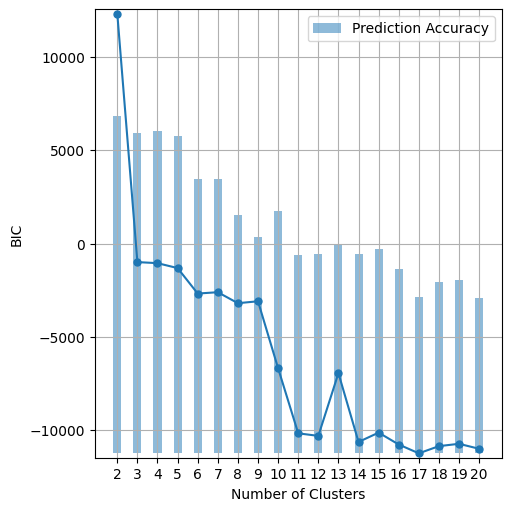

In [96]:
#attributes_to_cluster = ccat_active_loads + ccon_active_loads
subset_criteria = {'IECC_climate_code': '6A'} #'TYPEHUQ': 3
da, metrics = cluster_subset(
    categorical_columns, continuous_columns, subset_criteria, evaluate_gmm, bic_only=True)
print('Attributes to cluster:')
print(categorical_columns + continuous_columns)

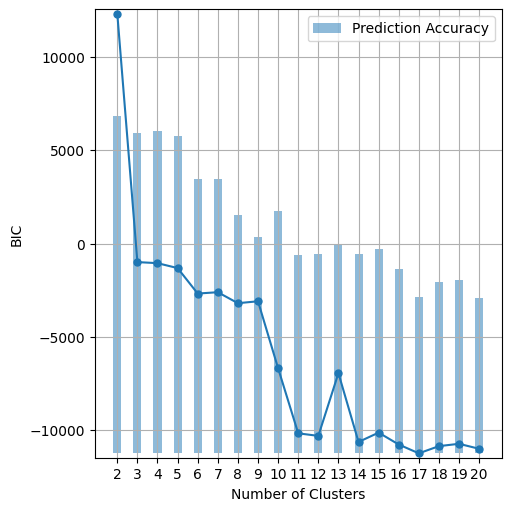

In [272]:
ccat = categorical_columns
ccon = continuous_columns
subset = subset_criteria
cluster_method = evaluate_gmm
attributes = ccat + ccon
indices = select(df, by=subset).index
da = df_computed.loc[indices][attributes]
#ccat, ccon = auto_detect_cat(da)
interval, metrics = cluster_method(sep_cols_and_preprocess(da, cols_cat=ccat, cols_con=ccon, cols_scl=[])[0])

fig, axes = plt.subplots(1, 1, figsize=(5, 5), layout='constrained')
bics = [m.BIC for m in metrics]
bmax = np.max(bics)
bmin = np.min(bics)
axes.plot(interval, bics, marker='o', markersize=5)
axes.set_xticks(interval, interval)
axes.set_ylabel('BIC')
axes.set_xlabel('Number of Clusters')
axes.grid(True)
ss = [m.silhouette for m in metrics]
smax = np.max(ss)
smin = np.min(ss)
axes.bar(interval, [ evaluate_mls(m, da.index, plot=False)[0]['Accuracy'].max() * (bmax - bmin) for m in metrics], .4, bottom=bmin, alpha=0.5, label='Prediction Accuracy')
axes.legend()
bg = (bmax - bmin) * 0.01
sg = (smax - smin) * 0.01
axes.set_ylim(bmin - bg, bmax + bg)
#
#plt.savefig('print/space_loads_clustering_new.png', bbox_inches='tight')
#plt.savefig('print/space_loads_clustering_new.pdf', bbox_inches='tight')

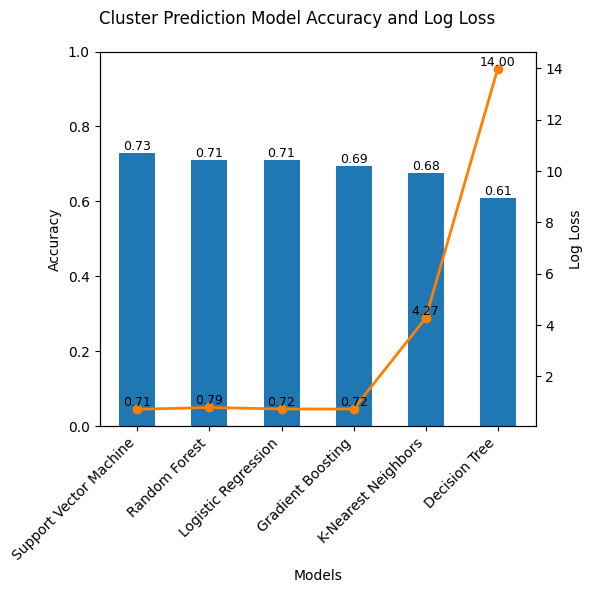

(                    Model  Accuracy   Log Loss
 0  Support Vector Machine  0.728370   0.713257
 1           Random Forest  0.710262   0.785504
 2     Logistic Regression  0.710262   0.724808
 3       Gradient Boosting  0.694165   0.724741
 4     K-Nearest Neighbors  0.676056   4.270726
 5           Decision Tree  0.609658  13.998226,
 0    Support Vector Machine
 1             Random Forest
 2       Logistic Regression
 3         Gradient Boosting
 4       K-Nearest Neighbors
 5             Decision Tree
 Name: Model, dtype: object)

In [75]:
N = 3
N = N - 2 
evaluate_mls(metrics[N], da.index)

In [478]:
sub_archetype_category = 'SpaceLoads'
dump(
    metrics[3 - 2].pipelines['Support Vector Machine'],
    f'models/{sub_archetype_category}_all.joblib'
)

['models/SpaceLoads_all.joblib']

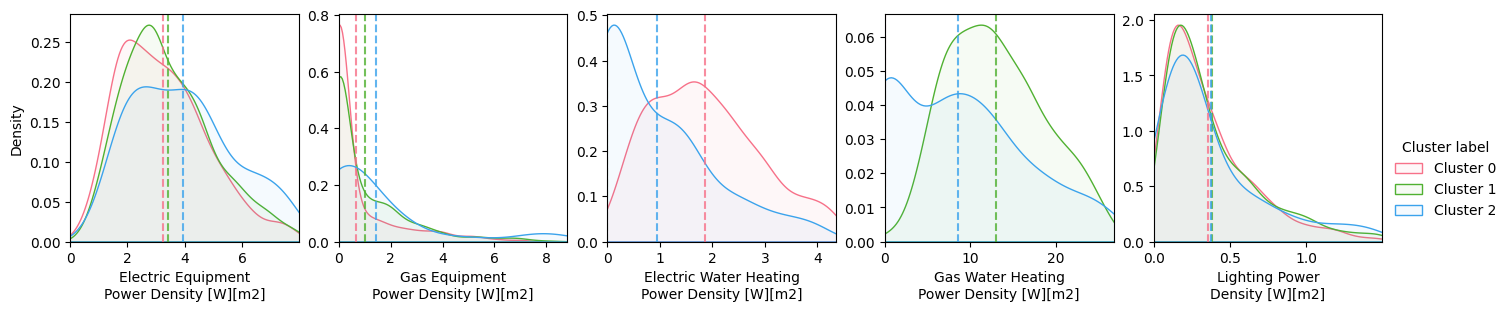

In [270]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), layout='constrained')
feature_names = ['Electric Equipment\nPower Density [W][m2]', 'Gas Equipment\nPower Density [W][m2]', 'Electric Water Heating\nPower Density [W][m2]', 'Gas Water Heating\nPower Density [W][m2]', 'Lighting Power\nDensity [W][m2]']
for j, cc in enumerate(continuous_columns):
    Q = 0.95
    cluster_metric = metrics[N]
    feature = cc
    df_plot = da.copy()
    df_plot['label'] = cluster_metric.labels
    # Filter the data to cap at the specified quantile
    cap_value = df_plot[feature].quantile(Q)
    df_plot = df_plot[df_plot[feature] <= cap_value]
    cluster_palette = sns.color_palette("husl", n_colors=df_plot['label'].nunique())
    # Create a KDE plot for each cluster
    ax = axes[j]
    for i, cluster in enumerate(np.sort(df_plot['label'].unique())):
        cluster_data = df_plot.loc[df_plot['label']  == cluster][feature]
        mean = cluster_data.mean()
        variance = cluster_data.var()
        #sns.kdeplot(cluster_data, label=f'{cluster} (μ={mean:.2f}, σ²={variance:.2f})', fill=False, alpha=0.6)
        # Plot KDE
        kde = sns.kdeplot(
            cluster_data, 
            label=f'Cluster {cluster}', 
            fill=True, 
            alpha=0.05, 
            color=cluster_palette[i],
            ax=ax
        )
        
        # Add vertical line for the mean
        ax.axvline(mean, linestyle='--', color=cluster_palette[i], alpha=0.8)
    
    #ax.set_title(f'{feature} by cluster label')
    ax.set_xlabel(f'{feature_names[j]}')
    ax.set_ylabel('Density' if j == 0 else '')
    ax.set_xlim(0, df_plot[feature].max())
    if j == 4:
        ax.legend(title=f'Cluster label', frameon=False, bbox_to_anchor=(1, .05))

plt.savefig('print/space_loads_new_5_plots.png', bbox_inches='tight')
plt.savefig('print/space_loads_new_5_plots.pdf', bbox_inches='tight')

In [105]:
dac = da.copy()
dac['label'] = metrics[N].labels
tpl = compute_cluster_statistics(dac, 'label', categorical_columns, continuous_columns,).sort_values('Cluster')
tpl

,Cluster,RC_equipment_power_density,RC_gas_power_density,RC_DHW_elec_power_density,RC_DHW_gas_power_density,RC_lighting_power_density
1,0,3.497462,0.669610,2.527796,0.000000,0.410793
0,1,3.827999,1.011083,0.000000,14.781312,0.468724
2,2,4.310670,16.350021,1.129307,9.895369,0.671365


In [190]:
dac.groupby('label').agg([
    lambda x: x.quantile(0.25),
    'median',
    'mean',
    lambda x: x.quantile(0.75),
]).rename(columns={
    '<lambda_0>':'25%',
    '<lambda_1>':'75%',
})

RC_equipment_power_density                                \
                             25%    median      mean       75%   
label                                                            
0                       2.001547  3.127485  3.497462  4.338284   
1                       2.313505  3.257720  3.827999  4.631914   
2                       2.516322  3.957133  4.310670  5.431948   

      RC_gas_power_density                                   \
                       25%     median       mean        75%   
label                                                         
0                 0.000000   0.000000   0.669610   0.600626   
1                 0.000000   0.000000   1.011083   1.628481   
2                 0.963503  11.362588  16.350021  21.311547   

      RC_DHW_elec_power_density                                \
                            25%    median      mean       75%   
label                                                           
0                      1.101272  1.956409  2.527796  3.098023   
1                      0.000000  0.000000  0.000000  0.000000   
2                      0.000000  0.711405  1.129307  1.604388   

      RC_DHW_gas_power_density                                  \
                           25%    median       mean        75%   
label                                                            
0                     0.000000   0.00000   0.000000   0.000000   
1                     8.905092  13.06268  14.781312  18.546112   
2                     0.000000   8.05929   9.895369  15.040942   

      RC_lighting_power_density                                
                            25%    median      mean       75%  
label                                                          
0                      0.142225  0.282875  0.410793  0.516625  
1                      0.156760  0.293617  0.468724  0.584317  
2                      0.151425  0.282337  0.671365  0.716991

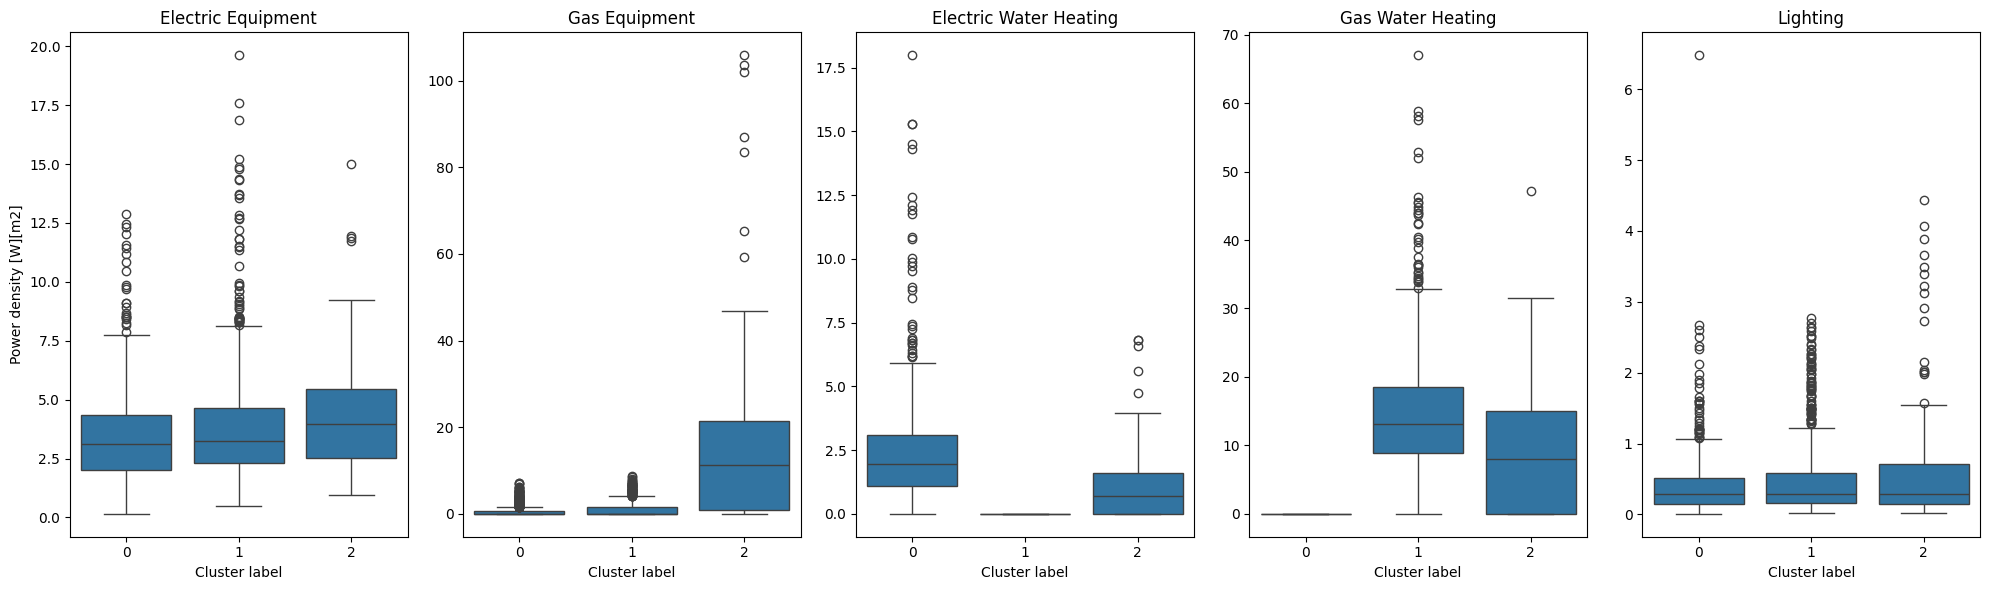

In [180]:
# Define features (excluding the categorical 'label' column)
features = [col for col in dac.columns if col != "label"]
feature_names = ['Electric Equipment', 'Gas Equipment', 'Electric Water Heating', 'Gas Water Heating', 'Lighting']

fig, axes = plt.subplots(1, 5, figsize=(20, 6),)

# Loop through each feature and create a violin plot
for i, feature in enumerate(features):
    sns.boxplot(x="label", y=feature, data=dac, ax=axes[i], )
    axes[i].set_title(f"{feature_names[i]}")
    axes[i].set_xlabel("Cluster label")
    axes[i].set_ylabel("Power density [W][m2]" if i == 0 else "")

# Adjust layout
plt.tight_layout()
plt.show()


### Comparison with RECS plotting

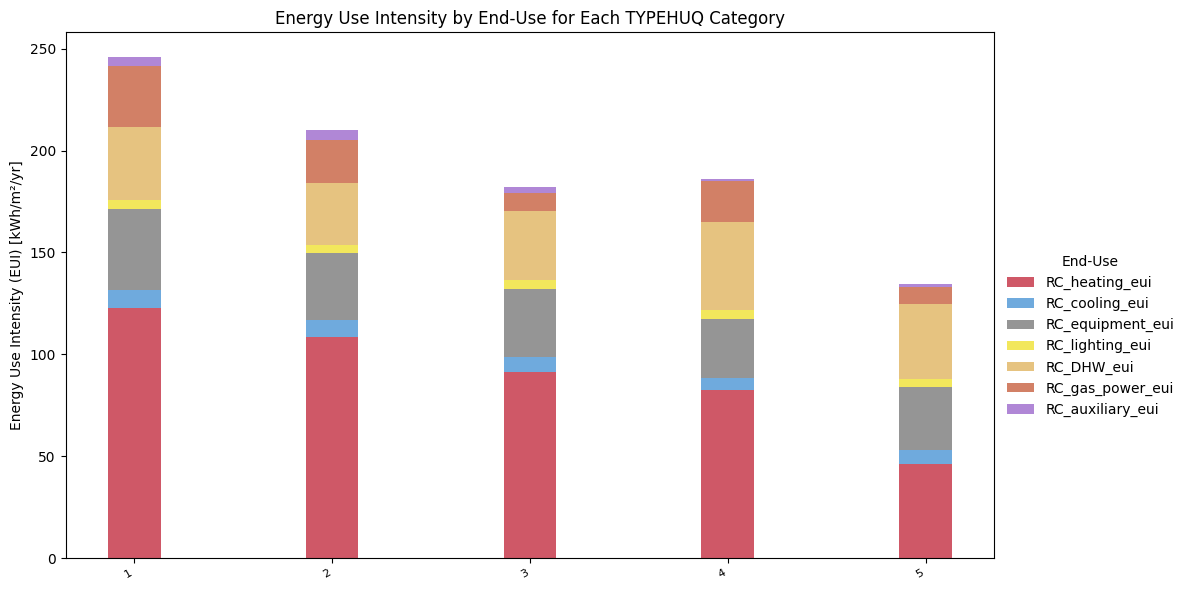

In [358]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df_6A = df_computed[df_computed['IECC_climate_code'] == '6A']
df_6A['RC_heating_eui'] = df_6A['RC_heating_eui'] / df_6A['HDD65'] * 6270
df_6A['RC_cooling_eui'] = df_6A['RC_cooling_eui'] / df_6A['CDD65'] * 890
# Define the end-use EUI columns
eui_columns = [
    #'RC_electricity_eui',
    #'RC_ofuel_eui',
    
    'RC_heating_eui',
    'RC_cooling_eui',
    'RC_equipment_eui',
    'RC_lighting_eui',
    'RC_DHW_eui',
    
    'RC_gas_power_eui',
    'RC_auxiliary_eui'
]
df_6A['TYPEHUQ'] = df_6A['TYPEHUQ'].astype(str)

# Define colors for each energy use category
eui_colors = ['#cf5867', '#6faadd', '#959595', '#f2e75c', '#e6c380', '#d28066', '#b087d6', '#ffbe3c', '#5da9ec']

# Group df_6A by TYPEHUQ and compute mean EUI per group
grouped_df = df_6A.groupby('TYPEHUQ')[eui_columns].mean()

# X-axis labels and position
categories = grouped_df.index.astype(str)
x = np.arange(len(categories)) * 3  # Space out bars

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6), layout='tight')

# Plot stacked bars for each TYPEHUQ category
for i, category in enumerate(categories):
    eui_sums = grouped_df.loc[category]

    bottom = 0  # Initialize stacking position
    for j, col in enumerate(eui_columns):
        ax.bar(x[i], eui_sums[col], bottom=bottom, color=eui_colors[j], label=col if i == 0 else "")
        bottom += eui_sums[col]

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=8, rotation=30, ha="right")
ax.set_ylabel("Energy Use Intensity (EUI) [kWh/m²/yr]")
ax.legend(title="End-Use", bbox_to_anchor=(1, 0.6), frameon=False)
ax.set_title("Energy Use Intensity by End-Use for Each TYPEHUQ Category")

# Save the figure if needed
if 'save_fig' in globals() and save_fig:
    plt.savefig('figure/energy_enduse_EUI_by_TYPEHUQ.png', bbox_inches='tight')
    plt.savefig('figure/energy_enduse_EUI_by_TYPEHUQ.pdf', bbox_inches='tight')

# Show the plot
plt.show()


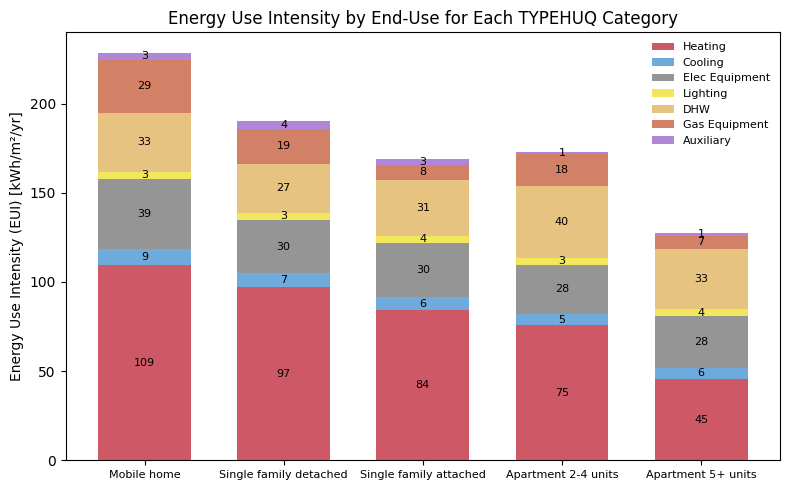

In [471]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df_computed is already defined
df_6A = df_computed[df_computed['IECC_climate_code'] == '6A']
df_6A['RC_heating_eui'] = df_6A['RC_heating_eui'] / df_6A['HDD65'] * 6270
df_6A['RC_cooling_eui'] = df_6A['RC_cooling_eui'] / df_6A['CDD65'] * 890

df_6A['RC_heating'] = df_6A['RC_heating'] / df_6A['HDD65'] * 6270
df_6A['RC_cooling'] = df_6A['RC_cooling'] / df_6A['CDD65'] * 890

# Define the end-use EUI columns
eui_columns = [
    'RC_heating',
    'RC_cooling',
    'RC_equipment_power',
    'RC_lighting',
    'RC_DHW',
    'RC_gas_power',
    'RC_auxiliary'
]

eui_labels = [
    'Heating', 'Cooling', 'Elec Equipment', 'Lighting', 'DHW', 'Gas Equipment', 'Auxiliary'
]

df_6A['TYPEHUQ'] = df_6A['TYPEHUQ'].astype(str)

# Define colors for each energy use category
eui_colors = ['#cf5867', '#6faadd', '#959595', '#f2e75c', '#e6c380', '#d28066', '#b087d6']

# Group df_6A by TYPEHUQ and compute mean EUI per group
grouped_df = df_6A.groupby('TYPEHUQ')[eui_columns].sum()
for c in grouped_df.columns:
    grouped_df[c] = grouped_df[c] / df_6A.groupby('TYPEHUQ')['total_sqm_en'].sum().values

# X-axis labels and position
categories = grouped_df.index.astype(str)
x = np.arange(len(categories)) * 3  # Space out bars

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')

# Plot stacked bars for each TYPEHUQ category
for i, category in enumerate(categories):
    eui_sums = grouped_df.loc[category]

    bottom = 0  # Initialize stacking position
    for j, col in enumerate(eui_columns):
        bar = ax.bar(x[i], eui_sums[col], width=2, bottom=bottom, color=eui_colors[j], label=eui_labels [j] if i == 0 else "")

        # Add text labels on each stack portion
        if eui_sums[col] > 0:
            ax.text(x[i], bottom + eui_sums[col] / 2, f"{int(eui_sums[col])}", ha='center', va='center', fontsize=8, color='black')

        bottom += eui_sums[col]

# Formatting
ax.set_xticks(x, ['Mobile home', 'Single family detached', 'Single family attached', 'Apartment 2-4 units', 'Apartment 5+ units'], fontsize=8)
ax.set_ylabel("Energy Use Intensity (EUI) [kWh/m²/yr]")
ax.legend(fontsize=8, frameon=False)
ax.set_title("Energy Use Intensity by End-Use for Each TYPEHUQ Category")

#plt.savefig('print/RECS_EUI_enduse_typehuq.png', bbox_inches='tight')
#plt.savefig('print/RECS_EUI_enduse_typehuq.pdf', bbox_inches='tight')

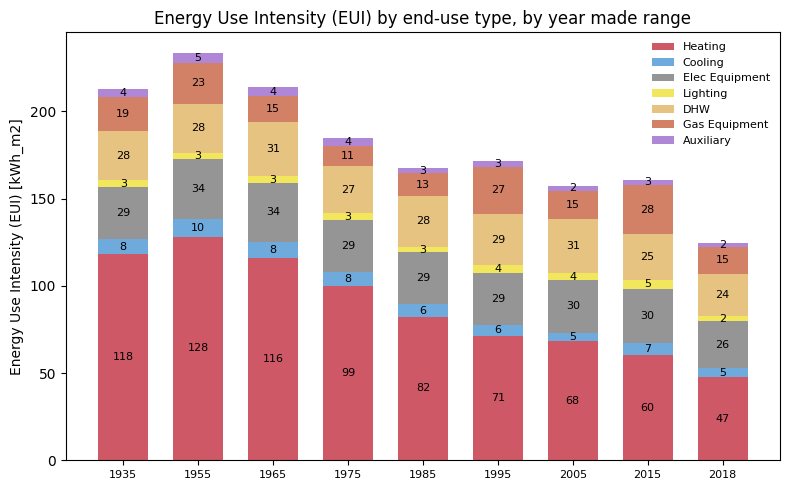

In [469]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df_computed is already defined
df_6A = df_computed[df_computed['IECC_climate_code'] == '6A']
df_6A['RC_heating_eui'] = df_6A['RC_heating_eui'] / df_6A['HDD65'] * 6270
df_6A['RC_cooling_eui'] = df_6A['RC_cooling_eui'] / df_6A['CDD65'] * 890

df_6A['RC_heating'] = df_6A['RC_heating'] / df_6A['HDD65'] * 6270
df_6A['RC_cooling'] = df_6A['RC_cooling'] / df_6A['CDD65'] * 890

# Define the end-use EUI columns
eui_columns = [
    'RC_heating',
    'RC_cooling',
    'RC_equipment_power',
    'RC_lighting',
    'RC_DHW',
    'RC_gas_power',
    'RC_auxiliary'
]
eui_labels = [
    'Heating', 'Cooling', 'Elec Equipment', 'Lighting', 'DHW', 'Gas Equipment', 'Auxiliary'
]

df_6A['YEARMADERANGE'] = df_6A['YEARMADERANGE'].astype(str)

# Define colors for each energy use category
eui_colors = ['#cf5867', '#6faadd', '#959595', '#f2e75c', '#e6c380', '#d28066', '#b087d6']

# Group df_6A by TYPEHUQ and compute mean EUI per group
grouped_df = df_6A.groupby('YEARMADERANGE')[eui_columns].sum()
for c in grouped_df.columns:
    grouped_df[c] = grouped_df[c] / df_6A.groupby('YEARMADERANGE')['total_sqm_en'].sum().values

# X-axis labels and position
categories = grouped_df.index.astype(str)
x = np.arange(len(categories)) * 3  # Space out bars

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')

# Plot stacked bars for each TYPEHUQ category
for i, category in enumerate(categories):
    eui_sums = grouped_df.loc[category]

    bottom = 0  # Initialize stacking position
    for j, col in enumerate(eui_columns):
        bar = ax.bar(x[i], eui_sums[col], width=2, bottom=bottom, color=eui_colors[j], label=eui_labels [j] if i == 0 else "")

        # Add text labels on each stack portion
        if eui_sums[col] > 0:
            ax.text(x[i], bottom + eui_sums[col] / 2, f"{int(eui_sums[col])}", ha='center', va='center', fontsize=8, color='black')

        bottom += eui_sums[col]

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=8,)
ax.set_ylabel("Energy Use Intensity (EUI) [kWh_m2]")
ax.legend( frameon=False, fontsize=8)
ax.set_title("Energy Use Intensity (EUI) by end-use type, by year made range")

#plt.savefig('print/RECS_EUI_enduse_year.png', bbox_inches='tight')
#plt.savefig('print/RECS_EUI_enduse_year.pdf', bbox_inches='tight')

array([  9076.63579186, 204149.05378162,  18370.6649077 ,   9395.29352744,
        14869.14594153])

In [309]:
import pandas as pd

def read_epw(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Skip the header (first 8 lines)
    weather_data = pd.read_csv(file_path, skiprows=8, header=None)

    # Define column names based on EPW format
    column_names = [
        "Year", "Month", "Day", "Hour", "Minute", "Data Source and Uncertainty Flags",
        "Dry Bulb Temperature (°C)", "Dew Point Temperature (°C)", "Relative Humidity (%)",
        "Atmospheric Station Pressure (Pa)", "Extraterrestrial Horizontal Radiation (Wh/m2)",
        "Extraterrestrial Direct Normal Radiation (Wh/m2)", "Horizontal Infrared Radiation Intensity (Wh/m2)",
        "Global Horizontal Radiation (Wh/m2)", "Direct Normal Radiation (Wh/m2)",
        "Diffuse Horizontal Radiation (Wh/m2)", "Global Horizontal Illuminance (lux)",
        "Direct Normal Illuminance (lux)", "Diffuse Horizontal Illuminance (lux)",
        "Zenith Luminance (Cd/m2)", "Wind Direction (°)", "Wind Speed (m/s)",
        "Total Sky Cover (tenths)", "Opaque Sky Cover (tenths)",
        "Visibility (km)", "Ceiling Height (m)", "Present Weather Observation",
        "Present Weather Codes", "Precipitable Water (mm)", "Aerosol Optical Depth",
        "Snow Depth (cm)", "Days Since Last Snowfall", "Albedo", "Liquid Precipitation Depth (mm)",
        "Liquid Precipitation Quantity (hr)"
    ]

    # Assign column names
    weather_data.columns = column_names

    return weather_data

# Example usage
epw_file = "../../RCTest/archive/Ithaca_2020.epw"
wea = read_epw(epw_file)
wea

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature (°C),Dew Point Temperature (°C),Relative Humidity (%),Atmospheric Station Pressure (Pa),...,Ceiling Height (m),Present Weather Observation,Present Weather Codes,Precipitable Water (mm),Aerosol Optical Depth,Snow Depth (cm),Days Since Last Snowfall,Albedo,Liquid Precipitation Depth (mm),Liquid Precipitation Quantity (hr)
0,2020,1,1,1,0,999999,-1.6,-4.7,79.42,977,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
1,2020,1,1,2,0,999999,-1.4,-4.6,78.60,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
2,2020,1,1,3,0,999999,-1.4,-4.6,78.69,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
3,2020,1,1,4,0,999999,-1.3,-4.7,77.84,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
4,2020,1,1,5,0,999999,-1.3,-4.8,77.30,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020,12,31,20,0,999999,-0.5,-3.2,81.74,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
8780,2020,12,31,21,0,999999,-1.1,-4.2,79.70,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
8781,2020,12,31,22,0,999999,-1.6,-4.6,79.85,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999
8782,2020,12,31,23,0,999999,-1.8,-4.8,80.10,978,...,999999,999999,999999,0.7,999999,999999,999999,0.12,999999,999999


In [350]:
import pandas as pd

def degree_days(weather):
    """
    Calculate daily Heating Degree Days (HDD) and Cooling Degree Days (CDD) based on a 65°F (18.33°C) baseline.
    Uses daily mean temperature (T_mean = (T_max + T_min) / 2).
    
    Parameters:
    weather (pd.DataFrame): DataFrame with columns 'Dry Bulb Temperature (°C)', 'Year', 'Month', and 'Day'.

    Returns:
    pd.DataFrame: A DataFrame with HDD and CDD aggregated by day in Fahrenheit-degree days.
    """
    # Define the baseline temperature in Fahrenheit
    base_temp_f = 65

    # Ensure required columns exist
    if 'Dry Bulb Temperature (°C)' not in weather.columns:
        raise ValueError("Missing required column: 'Dry Bulb Temperature (°C)'")

    # Convert temperature to numeric
    weather['Dry Bulb Temperature (°C)'] = pd.to_numeric(weather['Dry Bulb Temperature (°C)'], errors='coerce')

    # Compute daily max, min, and mean temperature
    daily_temps = weather.groupby(['Year', 'Month', 'Day'])['Dry Bulb Temperature (°C)'].agg(['max', 'min', 'mean'])
    daily_temps['T_mean_C'] = daily_temps['mean']

    # Convert daily mean temperature to Fahrenheit
    daily_temps['T_mean_F'] = daily_temps['T_mean_C'] * 1.8 + 32

    # Calculate HDD and CDD in Fahrenheit-degree days
    daily_temps['HDD'] = (base_temp_f - daily_temps['T_mean_F']).clip(lower=0)
    daily_temps['CDD'] = (daily_temps['T_mean_F'] - base_temp_f).clip(lower=0)

    # Reset index for final DataFrame
    degree_days_df = daily_temps[['HDD', 'CDD']].reset_index()

    return degree_days_df


In [354]:
degree_days(wea)[['HDD', 'CDD']].sum() * 365/366

HDD    6270.288627
CDD     890.188627
dtype: float64

### Ithaca 2020 HDD65 = 6270 CDD65 = 890

In [332]:
grouped_df

,RC_heating_eui,RC_cooling_eui,RC_equipment_eui,RC_lighting_eui,RC_DHW_eui,RC_gas_power_eui,RC_auxiliary_eui
TYPEHUQ,,,,,,,
1,146.666134,5.625365,39.866856,4.289478,35.873391,30.041029,4.045530
2,125.278835,6.123464,32.938206,3.969537,30.090122,21.363441,4.595933
3,103.403529,5.501825,33.291216,4.573055,33.840070,8.681192,3.167285
4,92.685329,4.088197,29.306940,4.176172,43.464281,19.753284,1.327245
5,52.860820,5.307914,30.579310,4.294435,36.718674,8.058883,1.456856
